# Topic Modelling - Job Domains 

In [2]:
import os
import json
import string
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re
import logging
import gensim
from gensim import corpora
import spacy

pd.options.mode.chained_assignment = None  # default='warn'


def preprocess(tokens):
    tokens_nop = [t for t in tokens if t not in string.punctuation]
    tokens_nop = [t.lower() for t in tokens_nop]
    # wnl = nltk.WordNetLemmatizer()
    stop = stopwords.words('english')
    stop.extend(
        ['armenian', 'armenia', 'job', 'title', 'position', 'location', 'responsibilities', 'application', 'procedures',
         'deadline', 'required', 'qualifications', 'renumeration', 'salary', 'date', 'company', 'yerevan',
         'eligibility', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
         'october', 'november', 'december'])
    tokens_nostop = [t for t in tokens_nop if t not in stop]
    # tokens_lem = [wnl.lemmatize(t) for t in tokens_nostop]
    tokens_clean = [t for t in tokens_nostop if len(t) >= 3]  # simple way to remove the offending " punctuations
    return tokens_clean


def plotWC(tokens):
    text_clean = " ".join(tokens)
    print(text_clean)
    wc = WordCloud(background_color="white").generate(text_clean)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(20, 9))
    fd = nltk.FreqDist(tokens)  # case sensitive!
    fd.plot(50)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


df_ori = pd.read_csv('../data/data job posts.csv')
df_ori.head()
print(df_ori.shape)
df = df_ori.drop_duplicates(['jobpost', 'Title'])
print(df.shape)
print("Removed {0} duplicates (based on jobpost + Title)".format(df_ori.shape[0] - df.shape[0]))



(19001, 24)
(18892, 24)
Removed 109 duplicates (based on jobpost + Title)


In [3]:
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub('\S*@\S*\s?', '', x))  # remove emails
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub('\s+', ' ', x))  # remove newlines
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub("\'", "", x))  # remove single quotes
re1 = '(www)'  # Word 1
re2 = '(\\.)'  # Any Single Character 1
re3 = '((?:[a-z][a-z0-9_]*))'  # Variable Name 1
re4 = '(\\.)'  # Any Single Character 2
re5 = '((?:[a-z][a-z0-9_]*))'  # Variable Name 2
rg = re.compile(re1 + re2 + re3 + re4 + re5, re.IGNORECASE | re.DOTALL)
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub(rg, "", x))
re1 = '((?:[a-z][a-z0-9_]*))'  # Variable Name 1
re2 = '(\\.)'  # Any Single Character 1
re3 = '((?:[a-z][a-z0-9_]*))'  # Word 1
rg = re.compile(re1 + re2 + re3, re.IGNORECASE | re.DOTALL)
df['jobpost'] = df['jobpost'].apply(lambda x: re.sub(rg, "", x))
df.jobpost = df.jobpost.apply(lambda x: re.sub('(\\d+)', "", x))  # remove numbers

df['jobpost_token'] = df.jobpost.map(word_tokenize)
df['jobpost_len'] = df.jobpost_token.apply(len)
df['jobpost_token_uniq'] = df.jobpost_token.apply(set)
df['jobpost_processed'] = df.jobpost_token.apply(preprocess)
# df['jobpost_processedtext'] = df.jobpost_processed.apply(lambda x: ' '.join(x))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['jobpost_processed'], min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['jobpost_processed']], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
#print(trigram_mod[bigram_mod[df.jobpost_processed[5]]])

df.jobpost_processed = make_bigrams(df.jobpost_processed)
df.jobpost_processed = lemmatization(df.jobpost_processed, allowed_postags=['NOUN', 'VERB'])  # 'ADJ',, 'ADV'])

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
dictionary = corpora.Dictionary(df['jobpost_processed'])
#print(dictionary)
dictionary.filter_extremes(no_below=3, no_above=0.7)
#print(dictionary)

/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [4]:

topic_num = 7

# Use the dictionary to prepare a DTM (using TF)
dtm_train = [dictionary.doc2bow(d) for d in df['jobpost_processed']]
lda = gensim.models.ldamodel.LdaModel(dtm_train, num_topics=topic_num, alpha='auto', chunksize=30, id2word=dictionary,
                                      passes=20, random_state=432)
lda.show_topics()
lda.show_topics(num_words=20)

dtopics_train = lda.get_document_topics(dtm_train)
# print topic distribution for 1st 5 rows
for i in range(0, 5):
    print(dtopics_train[i])




[(0, 0.119975545), (1, 0.10838561), (2, 0.42120668), (3, 0.020670587), (5, 0.018573191), (6, 0.30967)]
[(0, 0.5529387), (1, 0.19301182), (2, 0.036064904), (5, 0.11257046), (6, 0.09716331)]
[(0, 0.21326159), (1, 0.3510972), (2, 0.050571993), (5, 0.2761624), (6, 0.0974382)]
[(0, 0.052259926), (1, 0.49375182), (2, 0.0112226475), (3, 0.047561854), (4, 0.02636911), (5, 0.023485646), (6, 0.34534898)]
[(0, 0.29344884), (1, 0.032398142), (2, 0.0798206), (3, 0.36920053), (4, 0.06531269), (5, 0.07589083), (6, 0.08392841)]


In [5]:
lda.show_topics()

[(0,
  '0.024*"ability" + 0.021*"communication" + 0.019*"customer" + 0.018*"term" + 0.015*"sale" + 0.015*"line" + 0.015*"llc" + 0.014*"marketing" + 0.013*"service" + 0.012*"send"'),
 (1,
  '0.066*"project" + 0.036*"development" + 0.022*"program" + 0.019*"activity" + 0.018*"support" + 0.018*"implementation" + 0.013*"sector" + 0.013*"include" + 0.012*"community" + 0.011*"ensure"'),
 (2,
  '0.024*"report" + 0.016*"bank" + 0.015*"datum" + 0.014*"prepare" + 0.012*"indicate" + 0.011*"year" + 0.011*"accounting" + 0.010*"finance" + 0.010*"branch" + 0.010*"account"'),
 (3,
  '0.039*"development" + 0.037*"software" + 0.033*"design" + 0.025*"team" + 0.022*"developer" + 0.018*"web" + 0.017*"develop" + 0.016*"test" + 0.015*"system" + 0.015*"technology"'),
 (4,
  '0.034*"engineering" + 0.022*"construction" + 0.018*"safety" + 0.017*"test" + 0.014*"engineer" + 0.014*"store" + 0.013*"site" + 0.012*"register" + 0.011*"amd" + 0.011*"answer"'),
 (5,
  '0.018*"office" + 0.017*"course" + 0.015*"training" + 


7 topics

0, Sales and Marketing 

1, Project Management and Development 

2, Banking and Finance

3, Software Development 

4, Construction and Safety Engineering 

5, Education and Training 

6, Business Development and Management 



/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Topic Frequencies')

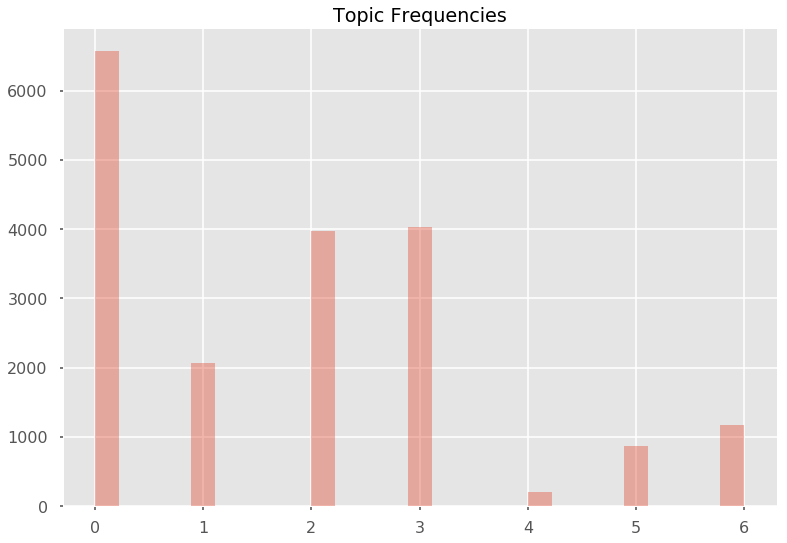

In [13]:
# get and plot the distribution of the topics
from operator import itemgetter
import matplotlib.style as style

import seaborn as sns
sns.distplot(top_train, kde=False).set_title('Topic Frequencies')
# style.use('seaborn-poster')
# fig, ax = plt.subplots(figsize=(16, 9))
# top_train = [max(t, key=itemgetter(1))[0] for t in dtopics_train]
# plt.hist(top_train, bins=topic_num)
# plt.title('Topic Frequencies')
# plt.show()